In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yaml

In [2]:
from catboost import CatBoostRegressor, CatBoostClassifier
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

/root/anaconda3/envs/cp/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics


def score_classifier_simple(target, predictions, threshold=0.5) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)
    response = (predictions > threshold).astype(int)

    metrics = {
        "roc_auc_score":   round((np.sqrt(roc_auc_score(target, predictions))),3),
        "av_precision_score": round((np.sqrt(average_precision_score(target, predictions))),3),
        "accuracy_score":  round(accuracy_score(target, response),3),
        "precision_score":  round(precision_score(target, response),3),
        "recall_score":   round((np.sqrt(recall_score(target, response))),3),
        "f1_score":       round(f1_score(target, response),3),
        "matthews_corrcoef":        round(matthews_corrcoef(target, response),3),
        } 
    return metrics

In [4]:
def calc_min_price_rolling(data, delta_h=24, features=None):
    if features is None:
        features = ['rarity', 'genesis', 'sneaker_type', 'level', 'mint']

    result = np.zeros(len(data))

    for i in range(len(data)):
        #i = 156
        sample = data.iloc[i]
        data_tmp = data.iloc[:i]
        data_tmp = data_tmp[data_tmp['date'] > (sample['date'] - pd.Timedelta(delta_h, unit='h'))]

        for feature in features:
            data_tmp = data_tmp[(data_tmp[feature] == sample[feature])]
        result[i] = data_tmp['price'].min()
    
    return result

# SETUP

In [5]:
CONFIG_DIR = '../app/'

In [6]:
with open(f"{CONFIG_DIR}config_prod.yml", 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.SafeLoader)

In [7]:
BD_NAME = f'{config["DATASET"]}.csv'
BD_FOLDER = './data'
VERSION = config["VERSION"]
START_DATE = '2022-09-03'
TETS_DATE = '2022-09-25'

In [8]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 500],
            'buy_count_24H': [0, 1000],
            'sell_count_24H': [0, 2000],
            'cancel_count_24H': [0, 1000],
            'token_all_activity_3H': [0, 30],
            'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [9]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

Columns (67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.


,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
0,1664474308,46384,35273,sell,0x702b3a7f41467a74388b2ed3e6b0c4554e0becf7,NaN,0.65,sneakers,common,hiker,...,434.0,8590.0,NaN,NaN,NaN,NaN,NaN,NaN,97.0,1.372449
1,1664474305,46383,34824,sell,0xdc664899ad56d6964a152be889f6ed453dd6d4f9,NaN,0.59,sneakers,common,ranger,...,433.0,8590.0,NaN,NaN,NaN,NaN,NaN,NaN,97.0,1.362245
2,1664474299,46222,62320,cancel,0x56b13353052e7cee7fb774d70994f99114d76ab3,NaN,NaN,sneakers,common,sprinter,...,434.0,8590.0,30879.0,8106.0,266.0,2893.0,6472.0,12049.0,97.0,1.362245
3,1664474296,46204,37075,cancel,0x42e4bd36ee327ba0519cc708163e22f691a0f68f,NaN,NaN,sneakers,common,ranger,...,435.0,8589.0,30879.0,8701.0,266.0,2893.0,6472.0,12049.0,97.0,1.372449
4,1664474269,46374,34824,cancel,0xdc664899ad56d6964a152be889f6ed453dd6d4f9,NaN,NaN,sneakers,common,ranger,...,435.0,8589.0,30879.0,8701.0,266.0,2895.0,6472.0,12049.0,97.0,1.372449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65015,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
65016,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
65017,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,904,0,252,1495,1831,2314,NaN,NaN
65018,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,NaN,NaN,15934,3984,256,4545,5225,15934,NaN,NaN


In [10]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [11]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65020 entries, 0 to 65019
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  42424 non-null  float64
 1   time_ownership             42424 non-null  float64
 2   wallet_box_mint            42424 non-null  float64
 3   wallet_sneaker_mint        42424 non-null  float64
 4   time_level_up              41929 non-null  float64
 5   time_level_up_for_mint     45302 non-null  float64
 6   base_mint_price_amt        45302 non-null  float64
 7   base_mint_price_azy        45302 non-null  float64
 8   base_mint_price_bnb        35279 non-null  float64
dtypes: float64(9)
memory usage: 4.5 MB


In [12]:
data.genesis

0        False
1        False
2        False
3        False
4        False
         ...  
65015     True
65016    False
65017    False
65018    False
65019     True
Name: genesis, Length: 65020, dtype: bool

In [13]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
25,1664473872,46349,60623,buy,0xefec729f279654011edc235604051fe9167dd4ae,0xe49eee4a85b1a1878219143bbff889e7f3c47f9b,0.61,sneakers,common,hiker,...,438.0,8589.0,30874.0,9455.0,261.0,2898.0,6467.0,12044.0,97.0,1.372449
47,1664473431,46365,24274,buy,0xe0c9eee17b0cc7dc3d0f97a8a70cd63e09610504,0x9c4dcfff0c981e6cb324fa490d3cb316c48b0b07,0.60,sneakers,common,hiker,...,447.0,8582.0,30866.0,9454.0,253.0,2892.0,6461.0,12037.0,98.0,1.310680
48,1664473419,46326,20991,buy,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0x87ee54bccc8d228bd042d40105f29fb49bfd0d92,0.60,sneakers,common,hiker,...,447.0,8582.0,30866.0,9454.0,253.0,2892.0,6461.0,12037.0,98.0,1.304348
50,1664473407,46245,16775,buy,0xe0fded54d2f39d3fd1b19cb31ed29cc362cd73e1,0x9c4dcfff0c981e6cb324fa490d3cb316c48b0b07,0.60,sneakers,common,sprinter,...,448.0,8581.0,30866.0,8102.0,253.0,2892.0,6461.0,12037.0,98.0,1.302885
51,1664473383,43728,55608,buy,0x31b47e17b24931088f5330e697262abd6ac98ccf,0x87ee54bccc8d228bd042d40105f29fb49bfd0d92,0.59,sneakers,common,hiker,...,449.0,8581.0,30866.0,9454.0,253.0,2893.0,6461.0,12037.0,98.0,1.307692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64957,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
64980,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
64994,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
64999,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


# data_quality

In [14]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

buy_count_12H more then expected. get: 567.0 | expected: 500
cancel_count_24H more then expected. get: 1348 | expected: 1000


In [15]:
data['mint'].isna().sum()

0

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11641 entries, 25 to 65013
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        11641 non-null  int64  
 1   mrk_id                                           11641 non-null  int64  
 2   token_id                                         11641 non-null  int64  
 3   event                                            11641 non-null  object 
 4   wallet_from                                      11614 non-null  object 
 5   wallet_to                                        11641 non-null  object 
 6   price                                            11641 non-null  float64
 7   item_type                                        11641 non-null  object 
 8   rarity                                           11641 non-null  object 
 9   sneaker_type               

In [17]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11641 entries, 25 to 65013
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  11641 non-null  float64
 1   time_ownership             11641 non-null  float64
 2   wallet_box_mint            11641 non-null  float64
 3   wallet_sneaker_mint        11641 non-null  float64
 4   time_level_up              11641 non-null  float64
 5   time_level_up_for_mint     11641 non-null  float64
 6   base_mint_price_amt        11641 non-null  float64
 7   base_mint_price_azy        11641 non-null  float64
 8   base_mint_price_bnb        9251 non-null   float64
dtypes: float64(9)
memory usage: 909.5 KB


In [18]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
25,1.657966e+09,240267.0,2.0,5.0,180.0,1800.0,300.0,200.0,0.451867
47,1.659556e+09,4756648.0,6.0,7.0,900.0,1800.0,300.0,200.0,0.450504
48,1.661425e+09,3185.0,2.0,5.0,900.0,1800.0,300.0,200.0,0.450504
50,1.659598e+09,2404224.0,0.0,0.0,900.0,1800.0,300.0,200.0,0.450504
51,1.657823e+09,684535.0,20.0,18.0,900.0,1800.0,300.0,200.0,0.450504
...,...,...,...,...,...,...,...,...,...
64957,1.657803e+09,18915.0,5.0,0.0,900.0,1800.0,300.0,200.0,NaN
64980,1.657800e+09,5178.0,6.0,10.0,900.0,1800.0,300.0,200.0,NaN
64994,1.657800e+09,446391.0,5.0,7.0,900.0,1800.0,300.0,200.0,NaN
64999,1.659970e+09,1062034.0,0.0,1.0,2700.0,1800.0,300.0,200.0,NaN


In [19]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [20]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [21]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [22]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11641 entries, 25 to 65013
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        11641 non-null  int64  
 1   mrk_id                                           11641 non-null  int64  
 2   token_id                                         11641 non-null  int64  
 3   event                                            11641 non-null  object 
 4   wallet_from                                      11614 non-null  object 
 5   wallet_to                                        11641 non-null  object 
 6   price                                            11641 non-null  float64
 7   item_type                                        11641 non-null  object 
 8   rarity                                           11641 non-null  object 
 9   sneaker_type               

In [24]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
25,1664473872,46349,60623,buy,0xefec729f279654011edc235604051fe9167dd4ae,0xe49eee4a85b1a1878219143bbff889e7f3c47f9b,0.61,sneakers,common,hiker,...,438.0,8589.0,30874.0,9455.0,261.0,2898.0,6467.0,12044.0,97.0,1.372449
47,1664473431,46365,24274,buy,0xe0c9eee17b0cc7dc3d0f97a8a70cd63e09610504,0x9c4dcfff0c981e6cb324fa490d3cb316c48b0b07,0.60,sneakers,common,hiker,...,447.0,8582.0,30866.0,9454.0,253.0,2892.0,6461.0,12037.0,98.0,1.310680
48,1664473419,46326,20991,buy,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0x87ee54bccc8d228bd042d40105f29fb49bfd0d92,0.60,sneakers,common,hiker,...,447.0,8582.0,30866.0,9454.0,253.0,2892.0,6461.0,12037.0,98.0,1.304348
50,1664473407,46245,16775,buy,0xe0fded54d2f39d3fd1b19cb31ed29cc362cd73e1,0x9c4dcfff0c981e6cb324fa490d3cb316c48b0b07,0.60,sneakers,common,sprinter,...,448.0,8581.0,30866.0,8102.0,253.0,2892.0,6461.0,12037.0,98.0,1.302885
51,1664473383,43728,55608,buy,0x31b47e17b24931088f5330e697262abd6ac98ccf,0x87ee54bccc8d228bd042d40105f29fb49bfd0d92,0.59,sneakers,common,hiker,...,449.0,8581.0,30866.0,9454.0,253.0,2893.0,6461.0,12037.0,98.0,1.307692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64957,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
64980,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
64994,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
64999,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


In [25]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [26]:
data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',])]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date
64524,1661076949,14027,23846,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7bdf18948f2b640ba7fea97875849038bd43da2c,0.73,sneakers,common,sprinter,...,NaN,16182,4070,391,4746,5443,16182,NaN,NaN,2022-08-21 10:15:49
64473,1661079343,14070,20408,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7dd69ca014565e2c9e1b47beabf57a4469d51fe1,0.73,sneakers,common,sprinter,...,NaN,16191,4072,387,4748,5448,16191,NaN,NaN,2022-08-21 10:55:43
64270,1661087557,14094,26385,buy,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0x06333746416b07371d84d1f862a352ec7ca1ab10,1.16,sneakers,common,hiker,...,NaN,16227,4332,384,4770,5469,16227,NaN,NaN,2022-08-21 13:12:37
64075,1661095945,14208,16352,buy,0xec04f1a68a3618028f3431ccf570508d95d34dce,0x3ae4020278e724bec4d24135bf9d42b6879a648f,0.69,sneakers,common,sprinter,...,NaN,16258,4083,380,4791,5492,16258,NaN,NaN,2022-08-21 15:32:25
63344,1661155769,14662,31425,buy,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0xf1a560df54f04b45e756d1cb36241fec633134a2,0.70,sneakers,common,sprinter,...,NaN,16415,4126,251,4875,5592,16415,NaN,NaN,2022-08-22 08:09:29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,1664473050,46264,47256,buy,0x6f1eb3642863ea040300e7bc2812ac87ac1e7314,0x9c4dcfff0c981e6cb324fa490d3cb316c48b0b07,0.58,sneakers,common,hiker,...,8581.0,30864.0,9454.0,251.0,2895.0,6461.0,12038.0,98.0,1.404762,2022-09-29 17:37:30
77,1664473146,43816,24757,buy,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0x531e9d48f84d99b00d6e65817b0ddf247f412999,0.59,sneakers,common,ranger,...,8581.0,30864.0,8694.0,251.0,2894.0,6461.0,12037.0,98.0,1.401914,2022-09-29 17:39:06
76,1664473179,46317,28797,buy,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0x531e9d48f84d99b00d6e65817b0ddf247f412999,0.59,sneakers,common,hiker,...,8581.0,30864.0,9454.0,251.0,2894.0,6461.0,12036.0,98.0,1.408654,2022-09-29 17:39:39
64,1664473284,46366,45865,buy,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0x06f8c40469f8ff0fbbef59b1bf3b3ef67911b304,0.58,sneakers,common,sprinter,...,8581.0,30866.0,8102.0,253.0,2894.0,6463.0,12037.0,98.0,1.370192,2022-09-29 17:41:24


In [27]:
#len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

In [28]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [29]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [30]:
data['token_sell_activity_6H'].max()

11.0

In [31]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [32]:
# Перекуп датасет

dupl_df = data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',], keep=False)]

In [33]:
data[data['token_id'] == 34874]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date,sum_activity_24H,sells_activity_24H
49860,1662138884,21406,34874,buy,0x92ede55a13c314bc7ca513734240d5d751b73008,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,1.07,sneakers,common,coacher,...,3942,323,1584,4052,13161,NaN,NaN,2022-09-02 17:14:44,1654,1.869180
45622,1662430561,23510,34874,buy,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,0x3273af210822c44afd7254510e612e4dbb1040a7,0.97,sneakers,common,coacher,...,4018,287,2007,3803,9987,NaN,NaN,2022-09-06 02:16:01,1079,2.341772


In [34]:
len(dupl_df)

2985

In [35]:
count_list = []
final_df = pd.DataFrame()

for token_id in dupl_df['token_id'].unique():
    data_tmp = dupl_df[dupl_df['token_id'] == token_id]
    #if data_tmp.iloc[0]['wallet_to'] == data_tmp.iloc[1]['wallet_from']:
    #print(len(data_tmp))
    i=0
    #for i in range(len(data_tmp)-1):
        #print(i)
    sample = data_tmp.iloc[i].copy()
    sample['sell_wallet_from'] = data_tmp.iloc[i+1]['wallet_from']
    sample['sell_price'] = data_tmp.iloc[i+1]['price']
    sample['sell_data'] = data_tmp.iloc[i+1]['date']
    sample['profit'] = (data_tmp.iloc[i+1]['price'] - ((data_tmp.iloc[i+1]['price']/100) * 5)) - data_tmp.iloc[i]['price']
    final_df = pd.concat([final_df, sample], ignore_index=True, sort=False, axis=1)
    
    #break

In [36]:
final_df = final_df.T
final_df

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date,sum_activity_24H,sells_activity_24H,sell_wallet_from,sell_price,sell_data,profit
0,1661065858,13953,31752,buy,0x8109ddb2277068a597cc9511e94f288b4f72e36c,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.76,sneakers,common,sprinter,...,16155,NaN,NaN,2022-08-21 07:10:58,911,4.683168,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.9,2022-09-02 20:03:07,0.095
1,1661069971,13988,23846,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,16168,NaN,NaN,2022-08-21 08:19:31,908,4.256881,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:15:49,0.1935
2,1661070010,13991,20408,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,16169,NaN,NaN,2022-08-21 08:20:10,910,4.227273,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:55:43,0.1935
3,1661079088,14089,26385,buy,0x25ad8afeb7b5c119fdbabb2ec99f84a611caea2a,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0.8,sneakers,common,hiker,...,16191,NaN,NaN,2022-08-21 10:51:28,978,4.469027,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,1.16,2022-08-21 13:12:37,0.302
4,1661082994,14081,26390,buy,0x627afb1341cb1ae3cb3546424709dba42d88bde9,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.72,sneakers,common,sprinter,...,16204,NaN,NaN,2022-08-21 11:56:34,998,4.557522,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.7,2022-08-29 16:25:54,-0.055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,1664437825,45035,45845,buy,0x702b3a7f41467a74388b2ed3e6b0c4554e0becf7,0x090de5cd85897400bde00b712e4005a8c4725bb4,0.57,sneakers,common,hiker,...,11909.0,87.0,1.343434,2022-09-29 07:50:25,2762,1.958589,0xcb6355317d43f6c2935a6cfae0fed3b9c81d7be0,0.53,2022-09-29 13:17:45,-0.0665
1360,1664439512,45825,49093,buy,0x04cd9cc35601bb748cbc98b549545f44068cddeb,0x281ea8fb9276ef2958a750adb87419fff5d481c1,0.56,sneakers,common,sprinter,...,11917.0,85.0,1.351759,2022-09-29 08:18:32,2708,1.959311,NaN,0.4,2022-09-29 10:57:25,-0.18
1361,1664443894,45893,61040,buy,0x6879fb90bf82adc9259e89d1c6370abb65aed8ed,0xae9dbe3feb9fd03945ed79f79142e8787fe47907,0.54,sneakers,common,hiker,...,11927.0,86.0,1.411458,2022-09-29 09:31:34,2596,1.902711,0xae9dbe3feb9fd03945ed79f79142e8787fe47907,0.67,2022-09-29 10:02:10,0.0965
1362,1664445694,45924,37465,buy,0x8f522535f239cd794f7d23df0a4d54b1c133a8dc,0x8f1a2341519a63d3a808e60575012f4625cf34ad,0.61,sneakers,common,ranger,...,11937.0,88.0,1.491892,2022-09-29 10:01:34,2527,1.848387,0x8f1a2341519a63d3a808e60575012f4625cf34ad,0.65,2022-09-29 10:07:15,0.0075


In [37]:
final_df.profit.median()

0.00275000000000003

In [38]:
final_df.profit.sum()

-47.13372499999992

In [39]:
len(final_df.groupby('wallet_to')['profit'].sum())

410

In [40]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 0).sum()

158

In [41]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 1).sum()

16

In [42]:
final_df.groupby('wallet_to')['profit'].sum().sort_values()

wallet_to
0xe58ea7792930a4b52b4b4701b88ec709b205c54d   -8.459425
0xee17c73127c83d876758f8750fd4c81710673d2b     -7.3965
0xfc2eb423826124d624db5f7d1a43f8f826750efe      -7.136
0x4a37b679463b90481547956da5b0432d45c867a5      -6.836
0x5eddc3624cf47c37eb7f056ab23150e502341d0a     -6.8065
                                                ...   
0xee731ff68f1b70358d4220eb964ed39feb89c6d9      2.3855
0xff06dbe17724093ce542247b28beef42dedb9f4b      4.3415
0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba       4.457
0xf3df1c64cb2e66400ef968caabfbe665457d25d4      8.9415
0x3273af210822c44afd7254510e612e4dbb1040a7      12.591
Name: profit, Length: 410, dtype: object

In [43]:
(final_df.wallet_to.value_counts() > 1).sum()

160

In [44]:
# фильтр по количеству сделок
len(final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10])

15

In [45]:
select_wallets = final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()

In [46]:
len(final_df)

548

In [47]:
# фильтр только прибыльных торгошей
final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 2].sort_values()

wallet_to
0xff06dbe17724093ce542247b28beef42dedb9f4b    4.3415
0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba     4.457
0xf3df1c64cb2e66400ef968caabfbe665457d25d4    8.9415
0x3273af210822c44afd7254510e612e4dbb1040a7    12.591
Name: profit, dtype: object

In [48]:
select_wallets = final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 2].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()
len(final_df)

282

In [49]:
final_df['sell_time'] = ((final_df['sell_data'] - final_df['date']) / np.timedelta64(1,'h')).astype(int)

In [50]:
final_df['sell_time']

1        1
2        2
28      11
54      51
57      57
        ..
1300    59
1309    15
1342     8
1344     8
1345    11
Name: sell_time, Length: 282, dtype: int64

In [51]:
final_df['target'] = final_df['profit']

In [52]:
final_df['target'].max()

5.577

In [53]:
final_df['target'].min()

-2.6075000000000004

# Model

In [54]:
data = final_df.copy()

In [55]:
int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint', 'buy_count_12H',
    'buy_count_24H','sum_activity_24H','token_all_activity_3H',
    'token_sell_activity_6H','time_level_up']
float_columns = ['base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability', 'price', 'min_price_all_24H',
    'sells_activity_24H',
    'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H','profit', 
    'base_mint_price_amt',
    'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    'price_azy', 
    'price_amt',
    'target']
cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [56]:
for columns in int_columns:
    data[columns] = data[columns].astype('int')

for columns in float_columns:
    data[columns] = data[columns].astype('float')

for columns in cat_columns:
    data[columns] = data[columns].astype('category')

In [57]:
data['genesis'] = data['genesis'].astype('bool')

In [58]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)
predict_price = model.predict(data[model.feature_names_])
predict_price = np.round(predict_price, 3)
data['predict'] = predict_price
#predict_price

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [59]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(data[model.feature_names_])
predict_price = np.round(predict_price, 2)
data['predict_base'] = predict_price

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [60]:
data['profit_by_predict_model'] = np.round((data['predict'] - ((data['predict']/100) * 5)) - data['price'], 3)

In [61]:
data['profit_by_predict_base_model'] = np.round((data['predict_base'] - ((data['predict_base']/100) * 5)) - data['price'], 3)

In [62]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,sum_activity_24H,sells_activity_24H,sell_wallet_from,sell_price,sell_data,profit,sell_time,target,profit_by_predict_model,profit_by_predict_base_model
1,1661069971,13988,23846,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.50,sneakers,common,sprinter,...,908,4.256881,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:15:49,0.1935,1,0.1935,0.294,0.308
2,1661070010,13991,20408,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.50,sneakers,common,sprinter,...,910,4.227273,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:55:43,0.1935,2,0.1935,0.085,0.346
28,1661191945,14985,23928,buy,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,1.70,sneakers,uncommon,coacher,...,1030,4.645455,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,7.66,2022-08-23 05:20:37,5.5770,11,5.5770,2.395,5.596
54,1661330758,15771,14732,buy,0x50246a336021f120dc42a694d574f6fa593c130f,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.70,sneakers,common,sprinter,...,938,3.081633,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.82,2022-08-26 12:24:47,0.0790,51,0.0790,0.071,0.108
57,1661342057,15841,24003,buy,0xbf4296b6e85d8aa032c091edf006bf5fe3f3b5b3,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.68,sneakers,common,sprinter,...,917,3.020000,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.85,2022-08-26 21:45:51,0.1275,57,0.1275,0.063,0.146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,1664207314,41598,39192,buy,0xaa5af02d18315b2c6cab933af28ebb07b854c8c6,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,3.50,sneakers,uncommon,coacher,...,2901,4.746711,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,3.8,2022-09-29 03:16:34,0.1100,59,0.1100,-0.176,0.024
1309,1664216987,41807,25036,buy,0x53dbf2d7969ca3fc63f94f7b493471efdad85678,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.74,sneakers,common,hiker,...,3001,4.105263,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,1.0,2022-09-27 10:27:08,0.2100,15,0.2100,0.145,0.258
1342,1664313911,43808,54485,buy,0x8b8dd1b82262fbea023be2fc97a8ed086c94a9b9,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.59,sneakers,common,coacher,...,3465,4.313580,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.68,2022-09-28 06:14:18,0.0560,8,0.0560,0.013,0.198
1344,1664316022,43906,21536,buy,0x6f57be359a598c7b73c99ba8872655f2601925c0,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.59,sneakers,common,coacher,...,3502,4.343137,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.69,2022-09-28 06:29:51,0.0655,8,0.0655,0.024,0.218


In [63]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

204

In [64]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [65]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [66]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
472,276.798229,0.111966,0.519497,1659203035.0,1125777.0,2.0,3.0,60,1800.0,300.0,200.0,0.643943,2022-09-03 07:06:55
473,276.883697,0.111953,0.516913,1660744494.0,150.0,0.0,0.0,900,1800.0,300.0,200.0,0.640935,2022-09-03 07:33:34
476,276.171518,0.111510,0.521967,1659438695.0,216.0,3.0,3.0,900,1800.0,300.0,200.0,0.647758,2022-09-03 08:35:22
484,277.109304,0.099167,0.552721,1658162819.0,519011.0,7.0,10.0,900,1800.0,300.0,200.0,0.669951,2022-09-03 13:00:04
485,277.268066,0.100288,0.550715,1659438695.0,273.0,3.0,3.0,900,1800.0,300.0,200.0,0.668205,2022-09-03 13:18:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1229,273.906438,0.066441,0.497715,1662729948.0,30.0,0.0,0.0,60,1800.0,300.0,200.0,0.593644,2022-09-24 08:13:12
1241,282.093910,0.064229,0.543991,1657801812.0,560992.0,4.0,5.0,2700,1800.0,300.0,200.0,0.624059,2022-09-24 13:17:54
1250,273.906438,0.066441,0.497715,1660141668.0,7871.0,2.0,2.0,0,1800.0,300.0,200.0,0.593644,2022-09-24 15:55:34
1255,278.293307,0.063748,0.520906,1657800039.0,39.0,16.0,20.0,900,1800.0,300.0,200.0,0.607350,2022-09-24 20:03:21


In [67]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 472 to 1257
Data columns (total 86 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   timestamp                                        204 non-null    int64         
 1   mrk_id                                           204 non-null    int64         
 2   token_id                                         204 non-null    int64         
 3   event                                            204 non-null    object        
 4   wallet_from                                      204 non-null    object        
 5   wallet_to                                        204 non-null    object        
 6   price                                            204 non-null    float64       
 7   item_type                                        204 non-null    category      
 8   rarity                               

In [68]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    # 'base_performance',
    # 'base_fortune',
    # 'base_joy',
    # 'base_durability',
    # 'performance',
    # 'fortune',
    # 'joy',
    # 'durability',
    'mint',
    #'buy_count_12H',
    #'buy_count_24H',
    #'min_price_all_24H',
    #'sum_activity_24H',
    #'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    #'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    'price',
    #'sell_price',
    #'profit',
    #'time_level_up', 
    #'time_level_up_for_mint', 
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    #'base_mint_price_bnb',
    #'price_bnb', 
    #'price_azy', 
    #'price_amt',
    #'predict',
    #'predict_base',
    'profit_by_predict_model',
    'profit_by_predict_base_model',
    ]
cat_features = [0, 1, 2,]

In [69]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.target.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.target.copy().reset_index(drop=True)

In [70]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostRegressor(
        depth=3,
        #learning_rate=0.01,
        #iterations=1000,
        loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  2.80it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:00,  2.91it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:01,  3.01it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:01,  3.10it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:01,  3.18it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:01,  3.18it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:02,  3.21it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:02,  3.22it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:02,  3.23it/s]iteritems is deprec

In [71]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,4.040000e-01,3.197000e-01
MAE,1.030000e-01,4.530000e-02
MSE,4.800000e-02,9.700000e-02
RMSE,1.700000e-01,1.408000e-01
MAPE,2.737903e+12,8.481311e+12


In [72]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,4.040000e-01,3.197000e-01
MAE,1.030000e-01,4.530000e-02
MSE,4.800000e-02,9.700000e-02
RMSE,1.700000e-01,1.408000e-01
MAPE,2.737903e+12,8.481311e+12


In [73]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.325,
 'MAE': 0.103,
 'MSE': 0.049,
 'RMSE': 0.22,
 'MAPE': 2722764480600.67}

In [74]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


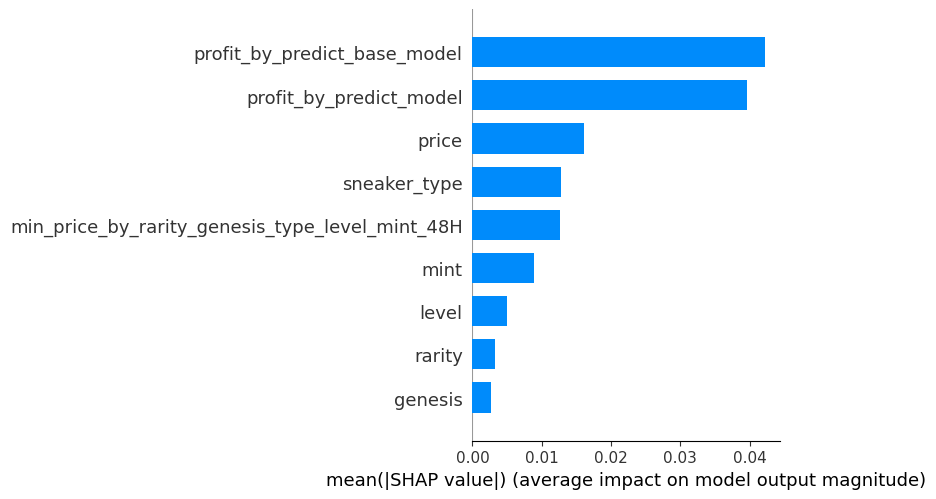

In [75]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [76]:
model = CatBoostRegressor(
    depth=3,
    #learning_rate=0.01,
    #iterations=1000,
    loss_function='MAPE',
    random_seed=42
    )

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

0:	learn: 0.1309599	total: 498us	remaining: 498ms
1:	learn: 0.1298470	total: 923us	remaining: 461ms
2:	learn: 0.1287042	total: 1.33ms	remaining: 444ms
3:	learn: 0.1275684	total: 1.78ms	remaining: 444ms
4:	learn: 0.1266635	total: 2.19ms	remaining: 435ms
5:	learn: 0.1257955	total: 2.56ms	remaining: 424ms
6:	learn: 0.1247897	total: 2.92ms	remaining: 415ms
7:	learn: 0.1239691	total: 3.33ms	remaining: 412ms
8:	learn: 0.1231200	total: 3.71ms	remaining: 409ms
9:	learn: 0.1223651	total: 4.06ms	remaining: 402ms
10:	learn: 0.1214214	total: 4.47ms	remaining: 402ms
11:	learn: 0.1206828	total: 4.9ms	remaining: 404ms
12:	learn: 0.1200188	total: 5.36ms	remaining: 407ms
13:	learn: 0.1193287	total: 5.8ms	remaining: 408ms
14:	learn: 0.1185409	total: 6.23ms	remaining: 409ms
15:	learn: 0.1176809	total: 6.65ms	remaining: 409ms
16:	learn: 0.1168831	total: 7.07ms	remaining: 409ms
17:	learn: 0.1163665	total: 7.48ms	remaining: 408ms
18:	learn: 0.1156551	total: 7.87ms	remaining: 406ms
19:	learn: 0.1150807	total

In [77]:
pred = model.predict(X_test)
pred = np.round(pred, 3)

score = score_regression_simple(y_test, pred,)
score

{'R2': -7.845, 'MAE': 0.196, 'MSE': 0.072, 'RMSE': 0.268, 'MAPE': 5.116}

In [78]:
submission = pd.DataFrame()
submission['profit'] = test_data.profit.copy().reset_index(drop=True)
submission['pred'] = pred

In [79]:
submission.profit.sum()

0.45299999999999974

In [80]:
submission

,profit,pred
0,-0.1385,0.141
1,0.0080,0.214
2,-0.0800,0.164
3,0.0790,0.170
4,0.0125,0.061
5,0.1075,0.112
6,0.1100,-0.602
7,0.2100,0.288
8,0.0560,0.189
9,0.0655,0.230


In [81]:
submission[submission['pred'] > 0.05].profit.sum()

0.34299999999999986

In [82]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': -7.764, 'MAE': 0.195, 'MSE': 0.071, 'RMSE': 0.266, 'MAPE': 5.049}

## Fit full Model

In [83]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

model = CatBoostRegressor(
    depth=3,
    #learning_rate=0.01,
    #iterations=1000,
    loss_function='MAPE',
    random_seed=42
    )

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_profit_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


0:	learn: 0.1276465	total: 1.31ms	remaining: 1.31s
1:	learn: 0.1265390	total: 1.77ms	remaining: 886ms
2:	learn: 0.1255653	total: 2.37ms	remaining: 789ms
3:	learn: 0.1246981	total: 2.92ms	remaining: 728ms
4:	learn: 0.1239834	total: 3.45ms	remaining: 686ms
5:	learn: 0.1230217	total: 4.24ms	remaining: 702ms
6:	learn: 0.1221435	total: 4.79ms	remaining: 679ms
7:	learn: 0.1214122	total: 5.23ms	remaining: 649ms
8:	learn: 0.1206811	total: 5.77ms	remaining: 636ms
9:	learn: 0.1199602	total: 6.31ms	remaining: 625ms
10:	learn: 0.1192511	total: 6.83ms	remaining: 614ms
11:	learn: 0.1182926	total: 7.33ms	remaining: 603ms
12:	learn: 0.1175545	total: 7.84ms	remaining: 596ms
13:	learn: 0.1167635	total: 8.25ms	remaining: 581ms
14:	learn: 0.1161236	total: 8.69ms	remaining: 571ms
15:	learn: 0.1153063	total: 9.07ms	remaining: 558ms
16:	learn: 0.1147718	total: 9.45ms	remaining: 547ms
17:	learn: 0.1143877	total: 9.79ms	remaining: 534ms
18:	learn: 0.1138448	total: 10.1ms	remaining: 524ms
19:	learn: 0.1129775	t

In [84]:
y

0      0.0770
1      0.0455
2      0.1740
3      0.3305
4      0.0685
        ...  
210    0.1100
211    0.2100
212    0.0560
213    0.0655
214    0.0230
Name: target, Length: 215, dtype: float64

### Test

In [85]:
i=102

In [86]:
sneaker_dict = {}

features = data.columns

for feature in features:
    sneaker_dict[feature] = data.iloc[i][feature]

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sneaker_dict

{'timestamp': 1663054328,
 'mrk_id': 28591,
 'token_id': 20236,
 'event': 'buy',
 'wallet_from': '0xececd5381a0a3786b6fe9860d5e1aab9d83fe314',
 'wallet_to': '0x3273af210822c44afd7254510e612e4dbb1040a7',
 'price': 0.85,
 'item_type': 'sneakers',
 'rarity': 'common',
 'sneaker_type': 'coacher',
 'level': 5,
 'base_performance': 7.8,
 'base_fortune': 4.7,
 'base_joy': 7.1,
 'base_durability': 4.9,
 'performance': 25.8,
 'fortune': 7.2,
 'joy': 10.6,
 'durability': 8.4,
 'mint': 2,
 'parent1': 4133.0,
 'parent2': nan,
 'genesis': True,
 'parent1_sneaker_type': nan,
 'parent2_sneaker_type': nan,
 'price_bnb': 293.69793468,
 'price_azy': 0.08944132,
 'price_amt': 0.55125225,
 'wallet_from_buy_count': 20.0,
 'wallet_from_all_count': 71.0,
 'token_all_activity_3H': 1,
 'token_sell_activity_6H': 1,
 'buy_count_12H': 97,
 'buy_count_24H': 299,
 'buy_count_48H': 534.0,
 'sell_count_12H': 249.0,
 'sell_count_24H': 694,
 'sell_count_48H': 1237.0,
 'cancel_count_12H': 116.0,
 'cancel_count_24H': 435

In [87]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

In [88]:
pd.Series(sneaker_dict)[model.feature_names_]

rarity                                              common
sneaker_type                                       coacher
genesis                                               True
level                                                    5
mint                                                     2
min_price_by_rarity_genesis_type_level_mint_48H       0.69
price                                                 0.85
profit_by_predict_model                              0.117
profit_by_predict_base_model                         0.052
dtype: object

In [89]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_profit_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict_price = model.predict(sample[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

0.142

In [90]:
data.iloc[i]['profit']

0.14750000000000008

iteritems is deprecated and will be removed in a future version. Use .items instead.


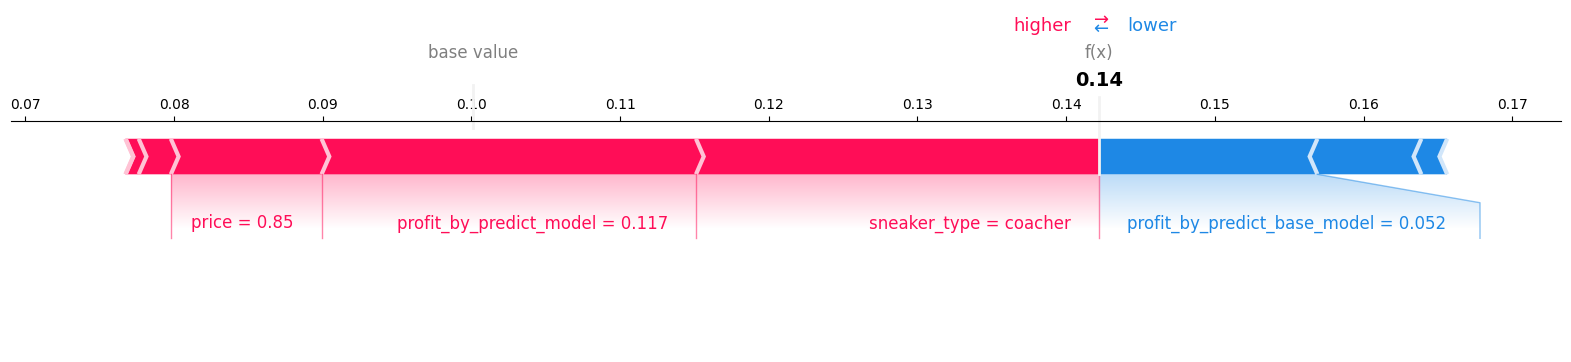

In [91]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)